# MMP Facility Event Studies

### What can we learn about the effectiveness of MMP through case studies of specific facilities?

<i> Maggie Hilderbran

**TO DO:**

* 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import yaml
from pathlib import Path
from IPython.display import clear_output
import sys

# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# turn off warning messages
warnings.filterwarnings('ignore')

In [2]:
# import & use utility functions sitting in 'main.py'
sys.path.append('../../../ca_mmp')
from policy_eval import main

##### 1. Reading in and preprocessing data.

In [3]:
print('Reading in configuration and data files.')
clear_output(wait=True)

# read in configuration file
print('Reading in configuration file.')
with open(Path().resolve().parent / 'config.yml', 'r') as file:
    configs = yaml.safe_load(file)
data_path = Path(configs['data_path'])
clear_output(wait=True)

# read in data
print('Reading violations file.')
violations = pd.read_excel(data_path / 'violations_export_2021-10-26.xlsx', dtype={'FACILITY_ID': str})
clear_output(wait=True)
print('Reading enforcements file.')
enforcements = pd.read_csv(data_path / 'enf_actions_export.csv',
                           dtype={'FACILITY ID': object},
                           parse_dates=['DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION', 'EFFECTIVE DATE.1'],
                           date_parser=lambda x: pd.to_datetime(x, errors='coerce'))
enforcements.rename(columns={'FACILITY ID': 'FACILITY_ID'}, inplace=True)
clear_output(wait=True)

Reading enforcements file.


In [4]:
print('Cleaning enforcements data.')
enforcements_clean = main.clean_enforcements(enforcements, mmp_only=False)
clear_output(wait=True)
del enforcements

Cleaning enforcements data.


In [5]:
print('Cleaning violations data.')
violations_clean = main.clean_violations(violations, mmp_only=False, effluent_only=False)
clear_output(wait=True)
del violations

Cleaning violations data.


In [6]:
# filter EPLs and estimate EPL issuance dates
print('Identifying MMP-related EPLs and estimating issuance dates.\n')
enforcements_mmp_epl = main.get_epls(enforcements_clean, issuance_dates_only=False, valid_only=False)
clear_output(wait=True)

Identifying MMP-related EPLs and estimating issuance dates.



##### 2. Plotting facility violations over time.

First, let's look at the facility's violation rate.

In [35]:
# facility ID for facility of interest
facility = '219398'

In [36]:
# get EPL dates for that facility
EPLs = enforcements_mmp_epl[enforcements_mmp_epl['FACILITY_ID'] == facility].estimated_epl_date
EPLs = pd.to_datetime(EPLs)
EPLs = EPLs.sort_values().drop_duplicates()
print(EPLs)

13600   2020-05-22
Name: estimated_epl_date, dtype: datetime64[ns]


In [37]:
# want to consider EPLs from our treatment period onwards (in theory, shouldn't have earlier ones)
EPLs = EPLs[EPLs >= main.TREATMENT_START_DATE]

In [38]:
# get monthly violation count
permittee_violations = violations_clean[violations_clean['FACILITY_ID'] == facility]
if len(EPLs) > 0:  
    permittee_violations['months_since_EPL'] = (permittee_violations['OCCURRED ON'].dt.to_period('M') - EPLs.dt.to_period('M').iloc[0]).apply(lambda x: x.n)
else:
    permittee_violations['months_since_EPL'] = (permittee_violations['OCCURRED ON'].dt.to_period('M') - pd.to_datetime(main.TREATMENT_START_DATE).to_period('M')).apply(lambda x: x.n)
viols_by_month = permittee_violations.groupby(permittee_violations['months_since_EPL'])['VIOLATION ID (VID)'].count().to_frame().reset_index()
viols_by_month.rename(columns = {'VIOLATION ID (VID)': 'violation_count'}, inplace=True)

# fill in violation timeseries with zeros for months with no violations
viol_months = pd.DataFrame({'months_since_EPL':[x for x in range(viols_by_month.months_since_EPL.min(), viols_by_month.months_since_EPL.max()+1)]})
viol_timeseries = pd.merge(left=viol_months,right=viols_by_month, on='months_since_EPL', how='outer').fillna(0).sort_values(by='months_since_EPL')

Missing violation data from before and/or after EPL.


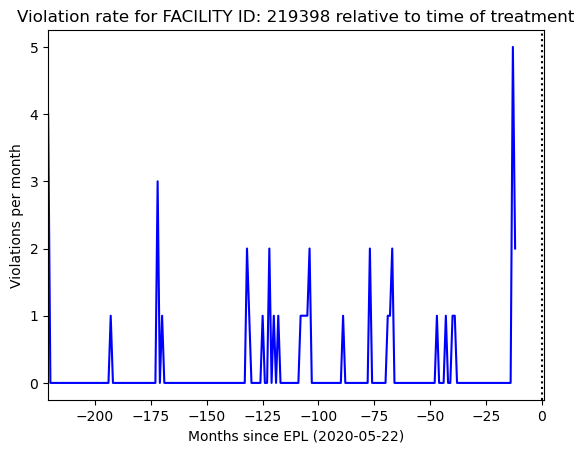

In [39]:
if not ((viols_by_month['months_since_EPL'].min() < 0) & (viols_by_month['months_since_EPL'].max() > 0)):
    print("Missing violation data from before and/or after EPL.")

plt.figure()
plt.title('Violation rate for FACILITY ID: '+facility+' relative to time of treatment')
if len(EPLs) > 0:
    plt.xlabel(f'Months since EPL ({EPLs.iloc[0]:%Y-%m-%d})')
else:
    plt.xlabel(f'Months since start of treatment ({pd.to_datetime(main.TREATMENT_START_DATE):%Y-%m-%d})')
plt.ylabel('Violations per month')
if len(EPLs) == 1:
    # if we only have one EPL, we set our x-axis limits to be all of our violations data
    if viols_by_month['months_since_EPL'].min() >= 0:
        plt.xlim(-1, max(viol_timeseries['months_since_EPL']))
    elif viols_by_month['months_since_EPL'].max() <= 0:
        plt.xlim(min(viol_timeseries['months_since_EPL']), 1)
    else:
        plt.xlim(min(viol_timeseries['months_since_EPL']), max(viol_timeseries['months_since_EPL']))
elif len(EPLs) > 1:
    # if we have multiple EPLs, cut off plot at next EPL date after the treatment one
    plt.xlim(min(viol_timeseries['months_since_EPL']), (EPLs.iloc[1].to_period('M')-EPLs.iloc[0].to_period('M')).n)
plt.plot(viol_timeseries['months_since_EPL'], viol_timeseries['violation_count'], color='blue')
# EPL issuance date is defined to be at t = 0
plt.axvline(0, linestyle=':', color='black');

In [40]:
# get enforcement dates for that facility
enforcements_clean_valid = enforcements_clean[enforcements_clean['STATUS.1'].apply(lambda x: x not in list(['Withdrawn', 'Draft']))]
permittee_enforcements = enforcements_clean_valid[(enforcements_clean_valid['FACILITY_ID'] == facility) &
                                                  (enforcements_clean_valid['ENFORCEMENT ACTION TYPE'] != 'Notice of Violation') &
                                                  (enforcements_clean_valid['ENFORCEMENT ACTION TYPE'] != 'Staff Enforcement Letter') &
                                                  (enforcements_clean_valid['ENFORCEMENT ACTION TYPE'] != 'Oral Communication')
                                                  ]
enforcement_dates = pd.to_datetime(permittee_enforcements['EFFECTIVE DATE.1'])
enforcement_dates = enforcement_dates.sort_values().drop_duplicates()
print(enforcement_dates)

46830   1995-11-03
47224   1995-12-07
48315   1996-01-25
46371   1997-09-19
42719   1999-09-17
40900   2000-03-16
12017   2002-12-06
12018   2008-02-06
7516    2008-12-04
7536    2013-11-21
7538    2014-09-25
13600   2020-08-04
Name: EFFECTIVE DATE.1, dtype: datetime64[ns]


In [41]:
permittee_enforcements

,REGION,FACILITY_ID,FACILITY NAME,AGENCY NAME,PLACE TYPE,PLACE SUBTYPE,FACILITY TYPE,AGENCY TYPE,# OF AGENCIES,PLACE ADDRESS,PLACE CITY,PLACE ZIP,PLACE COUNTY,PLACE LATITUDE,PLACE LONGITUDE,SIC CODE 1,SIC DESC 1,SIC CODE 2,SIC DESC 2,SIC CODE 3,SIC DESC 3,NAICS CODE 1,NAICS DESC 1,NAICS CODE 2,NAICS DESC 2,NAICS CODE 3,NAICS DESC 3,# OF PLACES,SOURCE OF FACILITY,DESIGN FLOW,THREAT TO WATER QUALITY,COMPLEXITY,PRETREATMENT,FACILITY WASTE TYPE,FACILITY WASTE TYPE 2,FACILITY WASTE TYPE 3,FACILITY WASTE TYPE 4,PROGRAM,PROGRAM CATEGORY,# OF PROGRAMS,WDID,REG MEASURE ID,REG MEASURE TYPE,REGION.1,ORDER #,NPDES # CA#,MAJOR-MINOR,NPDES TYPE,RECLAMATION,DREDGE FILL FEE,301H,APPLICATION FEE AMT RECEIVED,STATUS,STATUS DATE,EFFECTIVE DATE,EXPIRATION/REVIEW DATE,TERMINATION DATE,WDR REVIEW - AMEND,WDR REVIEW - REVISE/RENEW,WDR REVIEW - RESCIND,WDR REVIEW - NO ACTION REQUIRED,WDR REVIEW - PENDING,WDR REVIEW - PLANNED,STATUS ENROLLEE,INDIVIDUAL/GENERAL,FEE CODE,STAFF ASSIGNED,# OF STAFF ASSIGNED,SUPERVISOR,# OF SUPERVISORS,DIRECTION/VOICE,ENFORCEMENT ID (EID),REGION.2,ORDER / RESOLUTION NUMBER,ENFORCEMENT ACTION TYPE,EFFECTIVE DATE.1,ADOPTION / ISSUANCE DATE,ACHIEVE DATE,TERMINATION DATE.1,ACL ISSUANCE DATE,EPL ISSUANCE DATE,STATUS.1,TITLE,DESCRIPTION,PROGRAM.1,PROGRAM CATEGORY.1,# OF PROGRAMS.1,ASSIGNED STAFF,# OF ASSIGNED STAFF,SUPERVISOR.1,# OF SUPERVISORS.1,LATEST MILESTONE COMPLETION DATE,TOTAL ASSESSMENT AMOUNT,INITIAL ASSESSED AMOUNT,LIABILITY $ AMOUNT,PROJECT $ AMOUNT,LIABILITY $ PAID,PROJECT $ COMPLETED,TOTAL $ PAID/COMPLETED AMOUNT,AGENCY ISSUING ENF,DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION,RANK 1 VIOLATIONS,RANK 2 VIOLATIONS,RANK 3 VIOLATIONS,UNCLASSIFIED VIOLATIONS,ATOX VIOLATIONS #,BMP VIOLATIONS #,BASIN PLAN PROHIBITION VIOLATIONS #,CAT1 VIOLATIONS #,CAT2 VIOLATIONS #,CTOX VIOLATIONS #,DEFICIENT MONITORING VIOLATIONS #,DEFICIENT REPORT VIOLATIONS #,ENFORCEMENT ACTION VIOLATIONS #,FEES VIOLATIONS #,GROUNDWATER VIOLATIONS #,HYDRO MODIFICATION VIOLATIONS #,LATE REPORT VIOLATIONS #,OEV VIOLATIONS #,OTHER CODES VIOLATIONS #,PERMIT CONDITION VIOLATIONS #,PRETREATMENT VIOLATIONS #,REPORTING FAILURE TO NOTIFY VIOLATIONS #,SSO VIOLATIONS #,SURFACE WATER VIOLATIONS #,SWPPP VIOLATIONS #,UNAUTHORIZED DISCHARGE VIOLATIONS #,PRIORITY VIOLATIONS,TOTAL MMP VIOLATIONS #,EFFLUENT MMP SERIOUS,CHRONIC MMP,REPORTING MMP SERIOUS,TOTAL # OF VIOLATIONS LINKED TO THIS ENFORCEMENT ACTION,ECONOMIC BENEFIT,STAFF COST,MAXIMUM POTENTIAL LIABILITY
7516,5S,219398,Deer Creek WWTP,El Dorado Irrigation District,Utility,Wastewater Treatment Facility,Municipal/Domestic,Special District,1.0,1565 Deer Creek Road,Cameron Park,95682,El Dorado,38.62947,-120.98715,4952.0,Sewerage Systems,NaN,NaN,NaN,NaN,22132.0,Sewage Treatment Facilities,NaN,NaN,NaN,NaN,1.0,Reg Meas,3.6,1.0,A,N - POTW does not have EPA approved pretreatme...,Domestic wastewater,NaN,NaN,NaN,NPDMUNILRG,NPDESWW,1.0,5B090102001,361703.0,NPDES Permits,5S,R5-2008-0173,CA0078662,Major,MUN,2 - Producer-User,NaN,N,NaN,Historical,7/31/14,1/23/09,12/1/13,7/31/14,6/9/11,NaN,NaN,NaN,NaN,NaN,N,I,66 - NPDES Based on Flow,NaN,NaN,NaN,NaN,Passive,361708,5S,R5-2008-0174,Time Schedule Order,2008-12-04,12/4/08,NaN,11/20/13,NaN,NaN,Historical,"TSO R5-2008-0174 for El Dorado ID, Deer Creek ...",TSO R5-2013-0901 rescinds/replaces TSO R5-2008...,NPDMUNILRG,NPDESWW,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-04-30,0.0,39.0,1.0,0.0,0.0,0.0,0.0,0.0,51.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,52,NaN,NaN,NaN
7536,5S,219398,Deer Creek WWTP,El Dorado Irrigation District,Utility,Wastewater Treatment Facility,Municipal/Domestic,Special District,1.0,1565 Deer Creek Road,Cameron Park,95682,El Dorado,38.62947,-120.98715,4952.0,Sewerage Systems,NaN,NaN,NaN,NaN,22132.0,Sewage Treatment Facilities,NaN,NaN,NaN,NaN,1.0,Reg Meas,3.6,1.0,A,N - POTW does not have EPA approved pretreatme...,Domestic wastewater,NaN,NaN,NaN,NPDMUNILRG,NPDESWW,1.0,5B090102001,361703.0,NPDE

In [42]:
if len(EPLs) > 0:  
    permittee_enforcements['months_since_EPL'] = (permittee_enforcements['EFFECTIVE DATE.1'].dt.to_period('M') - EPLs.dt.to_period('M').iloc[0]).apply(lambda x: x.n)
else:
    permittee_enforcements['months_since_EPL'] = (permittee_enforcements['EFFECTIVE DATE.1'].dt.to_period('M') - pd.to_datetime(main.TREATMENT_START_DATE).to_period('M')).apply(lambda x: x.n)

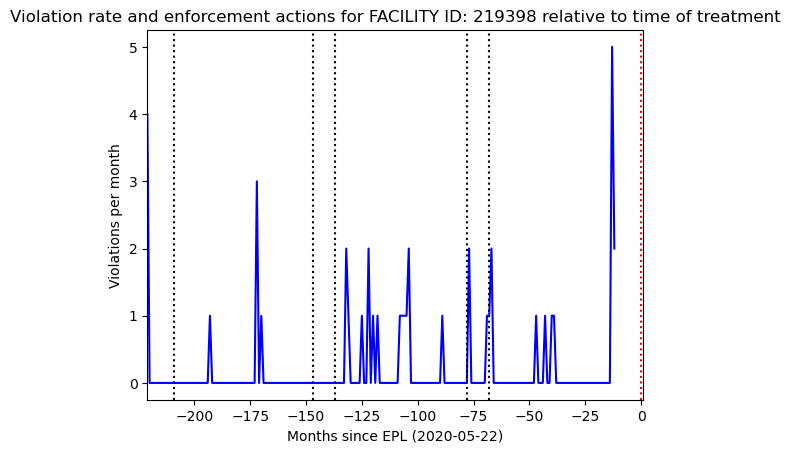

In [43]:
# If the permittee received an EPL, the red line will show the time of first EPL after the
# treatment start date (in theory, shouldn't be possible to have earlier EPLs); if the
# permittee didn't receive an EPL, the red line will be at the treatment start date.
# Black lines show *all* enforcements with a status of 'Active' or 'Historical' that
# aren't Notices of Violation, Staff Enforcement Letters, or Oral Communications.
plt.figure()
plt.title('Violation rate and enforcement actions for FACILITY ID: '+facility+' relative to time of treatment')
if len(EPLs) > 0:
    plt.xlabel(f'Months since EPL ({EPLs.iloc[0]:%Y-%m-%d})')
else:
    plt.xlabel(f'Months since start of treatment ({pd.to_datetime(main.TREATMENT_START_DATE):%Y-%m-%d})')
plt.ylabel('Violations per month')
if viols_by_month['months_since_EPL'].min() >= 0:
    plt.xlim(-1, max(viol_timeseries['months_since_EPL']))
elif viols_by_month['months_since_EPL'].max() <= 0:
    plt.xlim(min(viol_timeseries['months_since_EPL']), 1)
else:
    plt.xlim(min(viol_timeseries['months_since_EPL']), max(viol_timeseries['months_since_EPL']))
plt.plot(viol_timeseries['months_since_EPL'], viol_timeseries['violation_count'], color='blue')
# EPL issuance date is defined to be at t = 0
for i in range(len(permittee_enforcements['months_since_EPL'])):
    plt.axvline(permittee_enforcements['months_since_EPL'].iloc[i], linestyle=':', color='black')
plt.axvline(0, linestyle=':', color='red');